In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Finite case
$x\in[M]$

In [2]:
M = 100

### True function

In [3]:
_d = 20
param = np.random.uniform(size=_d) - 1/2
fmap = np.array([[(x/M)**y for y in range(_d)] for x in range(M)])
_f = np.matmul(fmap, param)
f = lambda x: _f[x]

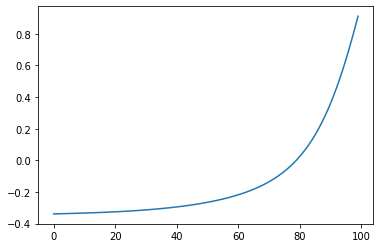

In [4]:
plt.plot(range(M), _f)

### Approximation with d random features (no noise)

In [5]:
def rfmap(d):
    return np.random.normal(size=(M,d))

In [6]:
def ols(X, y):
    A = np.matmul(X.T,X)
    b = np.matmul(X.T, y)
    theta = np.linalg.solve(A,b)
    return np.matmul(X, theta)

In [7]:
RF = rfmap(M)
err = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[:, :d]
    y = _f
    fhat = ols(X,y)
    fhats[d-1] = fhat
    err[d-1] = np.linalg.norm(fhat - _f)
    

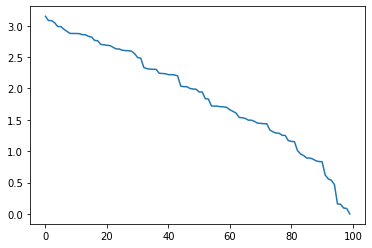

In [8]:
plt.plot(range(M), err)

In [17]:
xx = range(M)

def update(d = 1):
    plt.plot(xx, _f, xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim([-1,1])
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=1))

interactive(children=(IntSlider(value=1, description='d', min=1), Output()), _dom_classes=('widget-interact',)…